<a href="https://colab.research.google.com/github/leoazeved0/mvp_puc_rio/blob/main/Deep_Learning_Abelha_e_Formiga_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Objetivo**

O problema que escolhi para resolver é de visão computacional.

Usei o "Hymenoptera dataset", sendo a ordem Hymenoptera (himenópteros) um dos maiores grupos entre os insetos, compreendendo as vespas, abelhas e formigas.

A base de dados contém um total de 193 imagens de formigas e 204 de abelhas, que serão separadas em treino, teste e validação.

Este projeto tem como objetivo principal conseguir o melhor índice de reconhecimento possível das imagens, distinguindo-as entre abelhas e formigas.

Para este trabalho a deep residual learning para reconhecimento de imagem escolhida foi a Resnet18.

##Imports e download

In [2]:
!pip install gdown
import gdown
import os
import zipfile

In [12]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import requests
import pandas as pd
from io import BytesIO
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pickle
cudnn.benchmark = True
import seaborn as sn


In [23]:
file_id = "1wGjaVZ15NviFHPXHyX5pNWa6vyD0v856"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "dataset/train.zip"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1wGjaVZ15NviFHPXHyX5pNWa6vyD0v856
To: /content/dataset/train.zip
100%|██████████| 47.3M/47.3M [00:01<00:00, 43.2MB/s]


'dataset/train.zip'

In [24]:
destination = 'dataset/' # path onde se encontra o arquivo 'train.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

## Datasets das Imagens

In [25]:
img_train_dataset = torchvision.datasets.ImageFolder(root='/content/dataset/hymenoptera_data/train/')
img_valid_dataset = torchvision.datasets.ImageFolder(root='/content/dataset/hymenoptera_data/val/')

Renomeando as categorias

In [26]:
categories = ['formiga', 'abelha']

Função para visualizar imagem

In [7]:
#pause_time = 0.0005  # seconds between frames
# Função para visualização de imagens
def visualizar_img_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(15, 9))
  rows, cols = 3, 5
  for i in range(1, 11):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
    #time.sleep(pause_time)
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(categories[label])
    plt.axis('on')
    if istensor:
      plt.imshow(img.squeeze().permute(1, 2 , 0))
    else:
      plt.imshow(img)


plt.show()


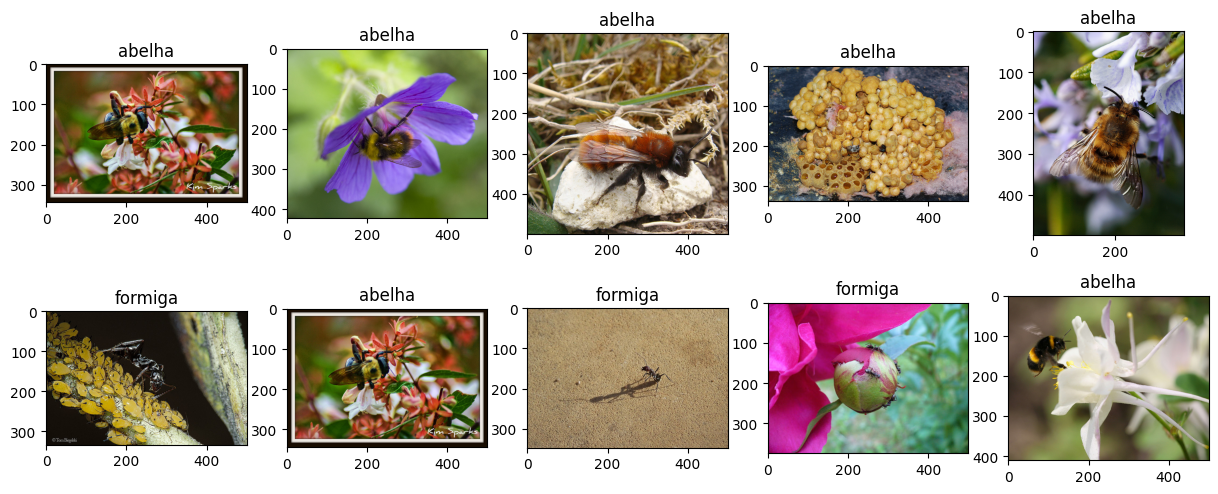

In [8]:
# Visualizar algumas imagens
visualizar_img_dataset(img_train_dataset)

##**Pré-processamento dos dados**

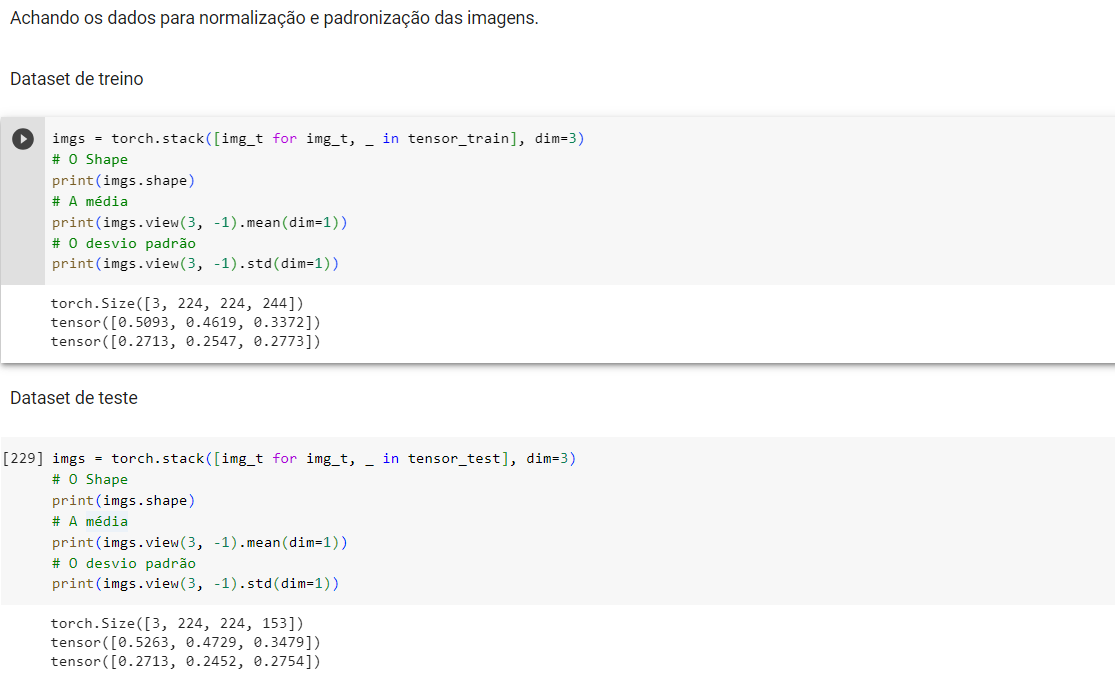

**Aplicando a normalização com os valores encontrados.**

In [27]:
prep_transform_train = T.Compose(
    [
       T.RandomResizedCrop(224),
       T.RandomHorizontalFlip(),
       T.ToTensor(),
       T.Normalize(
          (0.5093, 0.4619, 0.3372),
          (0.2713, 0.2547, 0.2773)
       )

    ]
)

prep_transform_test = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(
            (0.5263, 0.4729, 0.3479),
            (0.2713, 0.2452, 0.2754)
        )

    ]
)



ds_img_train=torchvision.datasets.ImageFolder(root='/content/dataset/hymenoptera_data/train/',
                                              transform=prep_transform_train)
ds_img_val=torchvision.datasets.ImageFolder(root='/content/dataset/hymenoptera_data/val/',
                                              transform=prep_transform_test)

In [10]:
ds_img_train

Dataset ImageFolder
    Number of datapoints: 244
    Root location: /content/dataset/hymenoptera_data/train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5093, 0.4619, 0.3372), std=(0.2713, 0.2547, 0.2773))
           )

In [11]:
ds_img_val

Dataset ImageFolder
    Number of datapoints: 153
    Root location: /content/dataset/hymenoptera_data/val/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.5263, 0.4729, 0.3479), std=(0.2713, 0.2452, 0.2754))
           )

Preparando os dados para treino, teste e validação com DataLoaders

In [28]:
ds_img_train, ds_img_test = torch.utils.data.random_split(ds_img_train, [171, 73])

In [29]:
bath_size = 64

train_loader = DataLoader(
    ds_img_train, batch_size=bath_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    ds_img_train, batch_size=bath_size, shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    ds_img_val, batch_size=bath_size, shuffle=True,
    num_workers=2
)

**Visualização de algumas imagens de treino com a normalização aplicada**

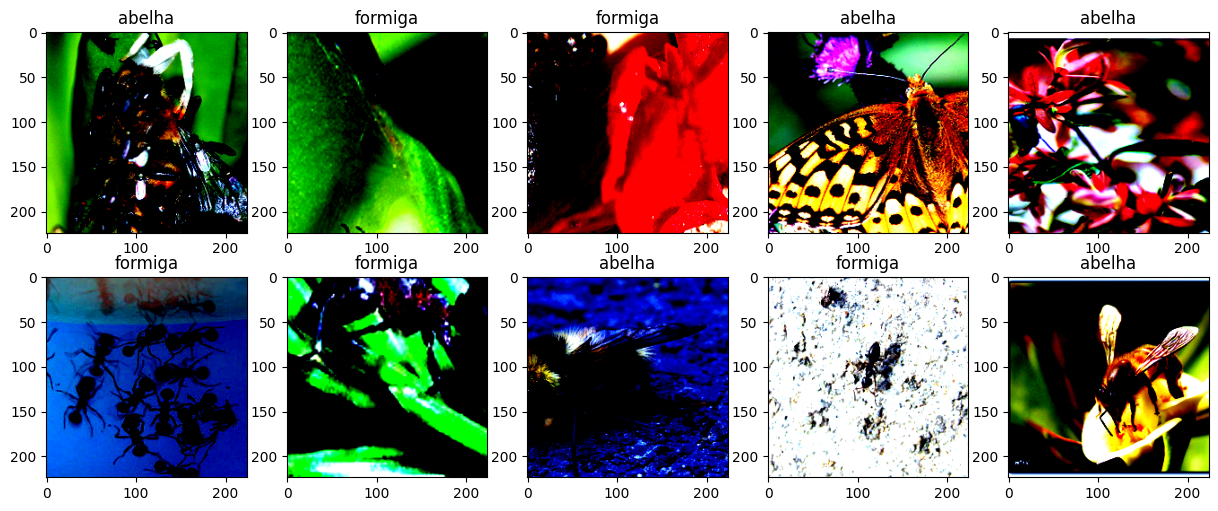

In [14]:
visualizar_img_dataset(ds_img_train, True)

**Visualização de algumas imagens de teste com a normalização aplicada**

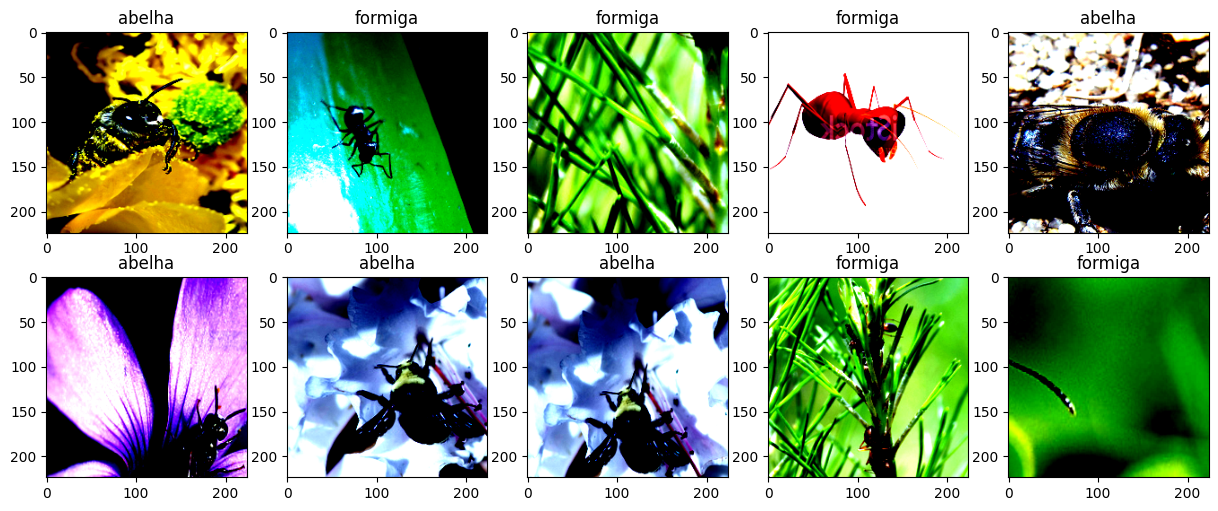

In [15]:
visualizar_img_dataset(ds_img_test, True)

##Device

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Rodando na {device}')

Rodando na cuda


## Funções

In [17]:
# treinamento
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:

    imgs, labels = imgs.to(device), labels.to(device)
    pred = model(imgs)
    loss = lossfunc(pred, labels)

    # zera os gradiente acumulados
    optimizer.zero_grad()
    # computa os gradiente
    loss.backward()
    # anda para a direção que reduz o erro local
    optimizer.step()
    # loss é um tensor; item para obter o float
    cumloss += loss.item()

  return cumloss / len(dataloader)
# validação
def validate(model, dataloader, lossfunc):
  model.eval()
  cumloss = 0.0
  with torch.no_grad():
   for imgs, labels in dataloader:
     imgs, labels = imgs.to(device), labels.to(device)
     pred = model(imgs)
     loss = lossfunc(pred, labels)
     cumloss += loss.item()
  return cumloss / len(dataloader)


In [18]:
# função para plotar as perdas
def plot_losses(losses):
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="14")
  ax.set_xlabel("Iteration", fontsize="14")
  ax.set_ylabel("Loss", fontsize="14")
  ax.set_title("Loss vs iterations", fontsize="14");

In [21]:
# função matriz de confusão
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1),
                        torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t,p] += 1
  return confusion_matrix

# função acurácia
def evaluate_accuracy(model, dataloader, classes, verbose = True):
  # prepare to count predictions for each class
  correct_pred = {classname:0 for classname in classes}
  total_pred = {classname:0 for classname in classes}
  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print('Accuracy for class {:5s} is {:.3f}%' .format(classname,
                                                          accuracy))
  print('Global accuracy is {:.3f}%'.format(100 * total_correct/total_prediction))
  return confusion_matrix


##Modelo

In [20]:
conv_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in conv_model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = conv_model.fc.in_features
conv_model.fc = nn.Linear(num_ftrs, 2)

conv_model = conv_model.to(device)

conv_lossfunc = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
conv_optimizer = optim.SGD(conv_model.fc.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


##Treinamento da rede

In [21]:
epochs = 100
train_losses = []
test_losses = []

local_save_model = "./dataset/modelo_salvo/"  # especifica a pasta onde baixar o arquivo
os.makedirs(local_save_model, exist_ok=True) # cria a pasta de destino se necessário

best_model_params_path = os.path.join(local_save_model, 'best_model_params.pth')
torch.save(conv_model.state_dict(), best_model_params_path)
best_loss = 100.0
since = time.time()

for t in range(epochs):
      train_loss = train(conv_model, train_loader, conv_lossfunc, conv_optimizer)
      train_losses.append(train_loss)
      test_loss = validate(conv_model, test_loader, conv_lossfunc)
      test_losses.append(test_loss)
      #if  t % 10 == 0:
      print(f'Epoch: {t} / Train Loss: {train_loss:.5f} and Test Loss: {test_loss:.5f}')

      if best_loss > test_loss:
        best_loss = test_loss
        torch.save(conv_model.state_dict(), best_model_params_path)

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Loss: {best_loss:.5f}')


Epoch: 0 / Train Loss: 0.82083 and Test Loss: 0.74168
Epoch: 1 / Train Loss: 0.76284 and Test Loss: 0.66591
Epoch: 2 / Train Loss: 0.68128 and Test Loss: 0.60227
Epoch: 3 / Train Loss: 0.58968 and Test Loss: 0.50388
Epoch: 4 / Train Loss: 0.51893 and Test Loss: 0.45495
Epoch: 5 / Train Loss: 0.42625 and Test Loss: 0.36409
Epoch: 6 / Train Loss: 0.39533 and Test Loss: 0.37713
Epoch: 7 / Train Loss: 0.38725 and Test Loss: 0.32685
Epoch: 8 / Train Loss: 0.31453 and Test Loss: 0.28626
Epoch: 9 / Train Loss: 0.30085 and Test Loss: 0.25172
Epoch: 10 / Train Loss: 0.27296 and Test Loss: 0.25429
Epoch: 11 / Train Loss: 0.23002 and Test Loss: 0.23882
Epoch: 12 / Train Loss: 0.24119 and Test Loss: 0.23072
Epoch: 13 / Train Loss: 0.23887 and Test Loss: 0.22450
Epoch: 14 / Train Loss: 0.23359 and Test Loss: 0.23513
Epoch: 15 / Train Loss: 0.23286 and Test Loss: 0.20904
Epoch: 16 / Train Loss: 0.22640 and Test Loss: 0.19113
Epoch: 17 / Train Loss: 0.22613 and Test Loss: 0.19471
Epoch: 18 / Train Lo

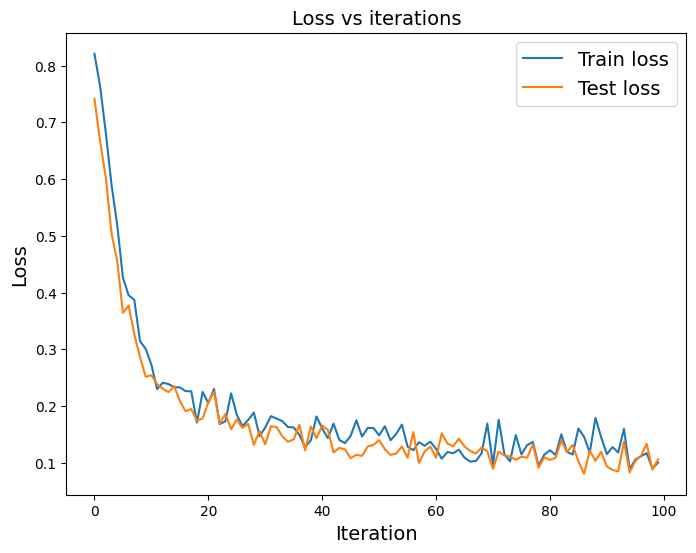

In [22]:
# plotando as perdas no treino e nos testes
conv_losses = {"Train loss": train_losses,"Test loss": test_losses }
plot_losses(conv_losses)

##Validação com dados não vistos

Carregando o modelo do google drive que eu já treinei para validar.

In [10]:
file_id = "1O-WIhJaaxYqE0wsOip-4kqRipW-ayfCv"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset/modelo_salvo/treinado/"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "./dataset/modelo_salvo/treinado/melhor_modelo_treinado.pth"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1O-WIhJaaxYqE0wsOip-4kqRipW-ayfCv
To: /content/dataset/modelo_salvo/treinado/melhor_modelo_treinado.pth
100%|██████████| 44.8M/44.8M [00:00<00:00, 133MB/s]


'./dataset/modelo_salvo/treinado/melhor_modelo_treinado.pth'

In [11]:
local_save_model = "/content/dataset/modelo_salvo/treinado/"  # especifica a pasta onde baixar o arquivo
os.makedirs(local_save_model, exist_ok=True) # cria a pasta de destino se necessário

best_model_params_path = os.path.join(local_save_model, 'melhor_modelo_treinado.pth')

Validando com os parâmetros carregados.

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Rodando na {device}')

new_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in new_model.parameters():
    param.requires_grad = False
num_ftrs = new_model.fc.in_features
new_model.fc = nn.Linear(num_ftrs, 2)
new_model.eval()
new_model = new_model.to(device)
new_model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model weights
confusion_matrix = evaluate_accuracy(new_model, val_loader, categories)


Rodando na cpu
Accuracy for class formiga is 97.143%
Accuracy for class abelha is 95.181%
Global accuracy is 96.078%


<Axes: >

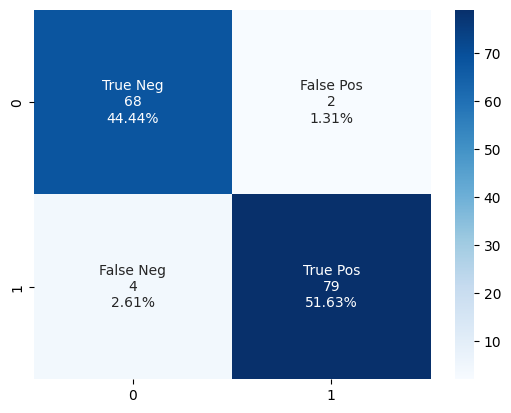

In [24]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/sum(confusion_matrix.flatten())]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

Uma foto não vista nem no treino e nem na validação

In [31]:
file_id = "16tMmacSHPh3ZK7PkmO4dE4LwAZYzZqJc"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "dataset/abelha_validacao.zip"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=16tMmacSHPh3ZK7PkmO4dE4LwAZYzZqJc
To: /content/dataset/abelha_validacao.zip
100%|██████████| 69.2k/69.2k [00:00<00:00, 25.8MB/s]


'dataset/abelha_validacao.zip'

In [32]:
destination = 'dataset/abelha' # path onde se encontra o arquivo 'train.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

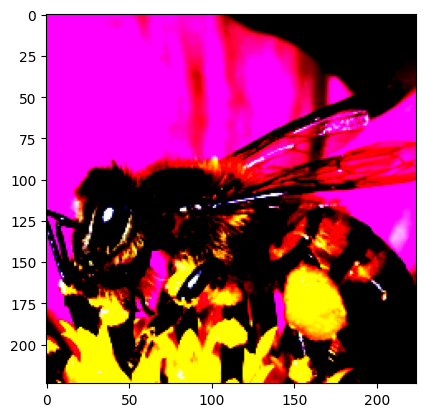

In [33]:
img = Image.open('/content/dataset/abelha/abelha.jpg')

img_tensor = prep_transform_test(img)
plt.imshow(img_tensor.squeeze().permute(1, 2 , 0))
batch = img_tensor.unsqueeze(0).to(device)
new_conv_avaliacao = new_model(batch)


formiga probability: 0.62%
abelha probability: 99.38%


<Axes: >

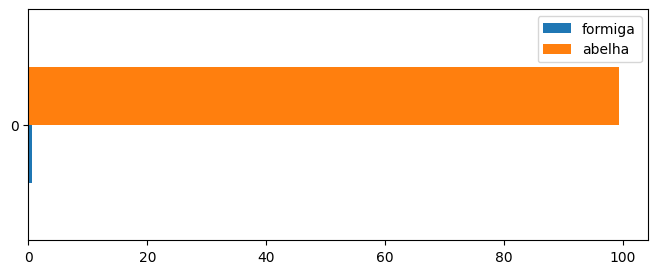

In [28]:
probs = torch.nn.functional.softmax(new_conv_avaliacao, dim=1) * 100
prob_dict = {}
for i, classname in enumerate(categories):
  prob = probs[0][i].item()
  print(f'{classname} probability: {prob:.2f}%')
  prob_dict[classname] = [prob]

df_prob = pd.DataFrame.from_dict(prob_dict)

df_prob.plot(kind ='barh', figsize=(8,3))

##**Conclusão**

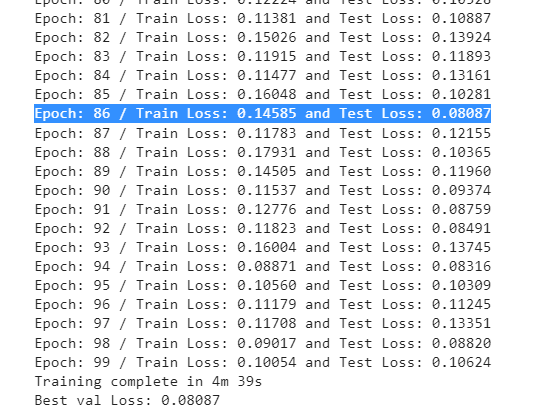

Depois de um treinamento de 100 épocas, o treinamento que ocorreu na época 86 foi o que obteve o menor "Loss" no reconhecimento do conjunto de teste.

Salvei este modelo para utilizá-lo em um conjunto de imagens ainda não visto pelo modelo, e de 153 imagens não conhecidas, o reconhecimento foi de mais de 96% do total, representando 97% para imagens de formigas e 95% para as de abelhas.

Para fins de redundância, testei novamente com uma imagem de abelha não presente em nenhum dos conjuntos usados, e o modelo apresentou uma probabilidade de mais de 99%, prevendo corretamente a classe da imagem.

Este modelo se apresentou muito eficaz no reconhecimento de imagens dos insetos escolhidos, alcançando o meu objetivo incicial, obtendo um índice de acerto bem expressivo.


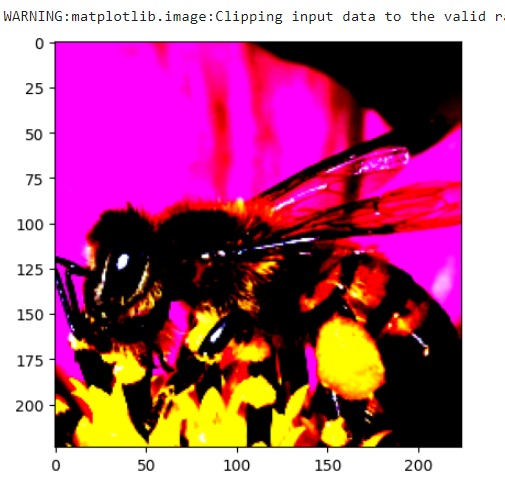

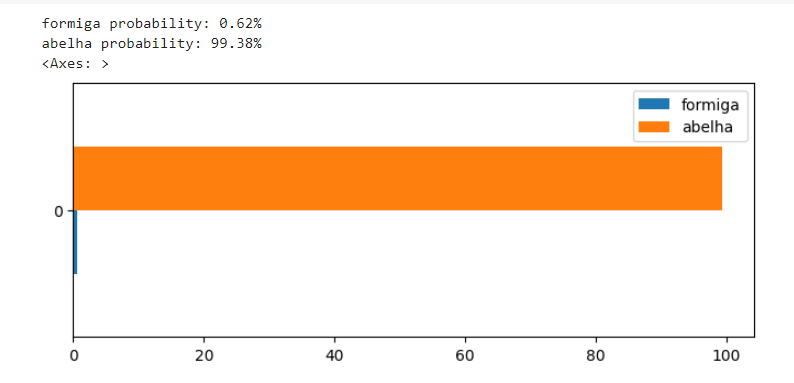